In [95]:
# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as sps

# Wenn Lab2Functions.py im gleichen Ordner liegt, reicht:
import Lab2Functions as ekg

# Matplotlib etwas hübscher
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True

# --- Globale Parameter ---
FS = 598951/600  # Abtastrate berechnet aus Anzahl Samples / Dauer in Sekunden
print(f"Abtastrate: {FS:.2f} Hz")
REST_FILES = {
    "Paul":    "EKG_Ruhe_Paul.csv",
    "Gabriel": "EKG_Ruhe_Gabriel.csv",
    "Jakob":   "EKG_Ruhe_Jakob.csv",
}

EXERCISE_FILE = "EKG_Leistung_Paul.csv"

# Parameter für Filter
CUTOFF_ECG_HZ = 40       # sinnvolle Cutoff-Frequenz zum Entfernen von Hochfrequenzrauschen
BUTTER_ORDER = 4

# Parameter für R-Zacken-Detektion (ggf. feinjustieren)
R_HEIGHT_PER   = 0.4
R_DISTANCE_PER = 0.5


Abtastrate: 998.25 Hz


In [96]:
def load_ecg_csv(filename, fs=FS):
    """
    Liest eine EKG-Datei mit Spalten 'index' und 'value' ein
    und ergänzt eine Zeitspalte in Sekunden.

    Rückgabe:
        df : DataFrame mit Spalten ['index', 'value', 'time_s']
    """
    df = pd.read_csv(filename, sep=";")
    # index ist hier ein Sample-Index - wir machen daraus eine Zeit in s
    df["time_s"] = (df["index"] - df["index"].iloc[0]) / fs
    return df


def butter_lowpass_filter(signal, cutoff_hz=CUTOFF_ECG_HZ, fs=FS, order=BUTTER_ORDER):
    """
    Butterworth-Tiefpassfilter (filtfilt, also keine Phasenverschiebung).
    cutoff_hz: Grenzfrequenz in Hz
    """
    nyquist = fs / 2.0
    Wn = cutoff_hz / nyquist   # normierte Cutoff-Frequenz (0..1)
    b, a = sps.butter(order, Wn, btype="low", analog=False)
    filtered = sps.filtfilt(b, a, signal)
    return filtered, (b, a, Wn)


def detect_rwaves(ecg_values, time_vec,
                  height_per=0.4, distance_per=0.5):
    """
    Wrapper um die drei Funktionen aus Lab2Functions.py

    ecg_values : 1D-Array mit EKG-Signal (z.B. df['ecg_filtered'].values)
    time_vec   : Zeit als pandas Series (z.B. df['time_s'])
    """
    # Schritt 1: Ableitung und rohe Peaks der Ableitung
    d_ECG, peaks_d_ecg = ekg.decg_peaks(ecg_values, time_vec)

    # Schritt 2: Peaks der Ableitung mit Threshold & Mindestabstand
    Rwave_peaks_d_ecg, threshold = ekg.d_ecg_peaks(
        d_ECG, peaks_d_ecg, time_vec, height_per, distance_per
    )

    # Schritt 3: R-Maxima im Originalsignal finden
    Rwave_t_obj = ekg.Rwave_peaks(ecg_values, d_ECG, Rwave_peaks_d_ecg, time_vec)

    # Je nach Implementierung: Series oder DataFrame -> robust abfangen
    import pandas as pd
    if isinstance(Rwave_t_obj, pd.DataFrame):
        t_r = Rwave_t_obj.iloc[:, 0].to_numpy()
    elif isinstance(Rwave_t_obj, pd.Series):
        t_r = Rwave_t_obj.to_numpy()
    else:
        t_r = np.asarray(Rwave_t_obj)

    return t_r, d_ECG, peaks_d_ecg, Rwave_peaks_d_ecg, threshold


def compute_hr_and_hrv(r_times,
                       min_hr_bpm=40.0,
                       max_hr_bpm=200.0,
                       ma_window=5):
    """
    Berechnet Herzfrequenz (HR) und HRV aus den R-Zacken-Zeitpunkten.

    - HR wird als 1/RR in bpm berechnet.
    - HRV = SDNN = Standardabweichung der RR-Intervalle in Millisekunden.
    - Ausreißer werden entfernt, indem nur HR zwischen min_hr_bpm und max_hr_bpm
      für HRV berücksichtigt werden.
    - Für Plots wird eine geglättete Herzfrequenz (moving average) zurückgegeben.

    Input:
        r_times    : 1D-Array mit R-Zacken-Zeitpunkten in Sekunden
        min_hr_bpm : minimale plausible Herzfrequenz
        max_hr_bpm : maximale plausible Herzfrequenz
        ma_window  : Fenstergröße für gleitenden Mittelwert (Anzahl Schläge)

    Output:
        hr_time    : Zeitpunkte (Sekunden) der gültigen HR-Werte
        hr_raw     : ungefilterte HR in bpm (nur gültige Werte)
        hr_smooth  : geglättete HR in bpm (gleitender Mittelwert)
        mean_hr    : mittlere HR in bpm (aus gültigen Werten)
        hrv_ms     : HRV (Std der RR-Intervalle) in Millisekunden
    """
    # RR-Intervalle in Sekunden (Abstand zwischen zwei R-Zacken)
    rr_intervals = np.diff(r_times)
    if len(rr_intervals) == 0:
        # zu wenige R-Zacken -> nichts berechenbar
        return np.array([]), np.array([]), np.array([]), np.nan, np.nan

    # Instantane HR in bpm
    hr_inst = 60.0 / rr_intervals
    hr_time_full = r_times[1:]  # HR gehört zum Intervall nach der ersten R-Zacke

    # Nur plausible HR-Werte berücksichtigen
    valid_mask = (hr_inst >= min_hr_bpm) & (hr_inst <= max_hr_bpm)
    if not np.any(valid_mask):
        return hr_time_full, hr_inst, hr_inst, np.nan, np.nan

    hr_valid = hr_inst[valid_mask]
    hr_time_valid = hr_time_full[valid_mask]
    rr_valid = rr_intervals[valid_mask]

    # HRV als Std der RR-Intervalle in Millisekunden (klassische SDNN)
    hrv_ms = np.std(rr_valid * 1000.0)

    # Mittlere HR
    mean_hr = np.mean(hr_valid)

    # einfache Glättung der HR über gleitenden Mittelwert
    if ma_window is not None and ma_window > 1 and len(hr_valid) >= ma_window:
        kernel = np.ones(ma_window) / ma_window
        hr_smooth = np.convolve(hr_valid, kernel, mode="same")
    else:
        hr_smooth = hr_valid.copy()

    return hr_time_valid, hr_valid, hr_smooth, mean_hr, hrv_ms

In [97]:
# --- Ruhe-EKG aller Teilnehmer einlesen & verarbeiten ---

rest_results = {}  # hier speichern wir alle relevanten Infos pro Person

for name, fname in REST_FILES.items():
    # Rohdaten laden
    df = load_ecg_csv(fname, fs=FS)

    # EKG filtern
    df["ecg_filtered"], _ = butter_lowpass_filter(
        df["value"].values, cutoff_hz=CUTOFF_ECG_HZ, fs=FS
    )

    # Zeit als Series
    time_series = df["time_s"]

    # R-Zacken detektieren
    r_times, d_ECG, peaks_d_ecg, Rpeaks_d_ecg, thr = detect_rwaves(
        df["ecg_filtered"].values, time_series
    )

    # HR & HRV berechnen
    hr_time, hr_raw, hr_smooth, mean_hr, hrv_ms = compute_hr_and_hrv(
        r_times,
        min_hr_bpm=40.0,
        max_hr_bpm=200.0,
        ma_window=5
    )

    rest_results[name] = {
        "df": df,
        "r_times": r_times,
        "d_ECG": d_ECG,
        "peaks_d_ecg": peaks_d_ecg,
        "Rpeaks_d_ecg": Rpeaks_d_ecg,
        "threshold_d_ecg": thr,
        "hr_time": hr_time,
        "hr_raw": hr_raw,
        "hr_smooth": hr_smooth,
        "HR_mean_bpm": mean_hr,
        "HRV_ms": hrv_ms,
    }

# Übersichtstabelle für die Ruhe-Messungen
rest_summary = pd.DataFrame.from_dict(
    {
        name: {
            "HR_mean_bpm": vals["HR_mean_bpm"],
            "HRV_ms": vals["HRV_ms"],
        }
        for name, vals in rest_results.items()
    },
    orient="index"
)

rest_summary

,HR_mean_bpm,HRV_ms
Paul,66.600783,85.095150
Gabriel,64.746882,75.540721
Jakob,87.918772,33.412433


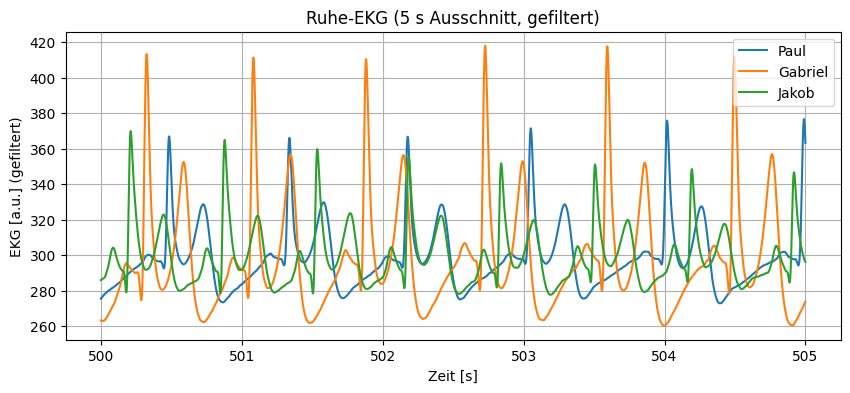

In [102]:
# --- 5 Sekunden des gefilterten Ruhe-EKG plotten ---

# beliebigen Zeitbereich wählen (z.B. von 10s bis 15s)
t_start = 500.0
t_window = 5.0
t_end = t_start + t_window

fig, ax = plt.subplots()
for name, res in rest_results.items():
    df = res["df"]
    mask = (df["time_s"] >= t_start) & (df["time_s"] < t_end)
    ax.plot(df["time_s"][mask], df["ecg_filtered"][mask], label=name)

ax.set_xlabel("Zeit [s]")
ax.set_ylabel("EKG [a.u.] (gefiltert)")
ax.set_title("Ruhe-EKG (5 s Ausschnitt, gefiltert)")
ax.legend()
plt.show()


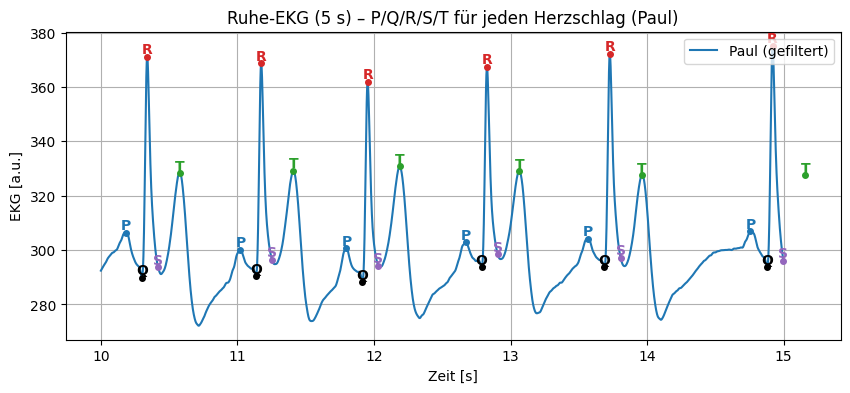

In [103]:
# --- Für eine Person (z.B. Paul) P/Q/R/S/T für JEDE Welle markieren ---

person_for_detail = "Paul"
res = rest_results[person_for_detail]
df = res["df"]
r_times = res["r_times"]

# Ausschnitt wählen
t_start = 10.0
t_window = 5.0
t_end = t_start + t_window

mask = (df["time_s"] >= t_start) & (df["time_s"] < t_end)

t_all = df["time_s"].to_numpy()
y_all = df["ecg_filtered"].to_numpy()

fig, ax = plt.subplots()
ax.plot(df["time_s"][mask], df["ecg_filtered"][mask],
        label=f"{person_for_detail} (gefiltert)")

# Feste Farben pro Welle
WAVE_COLORS = {
    "P": "#1f77b4",   # blau
    "Q": "#000000",   # schwarz
    "R": "#d62728",   # rot
    "S": "#9467bd",   # violett
    "T": "#2ca02c",   # grün
}


# Hilfsfunktion: lokalen Peak im Zeitfenster finden
def find_peak(kind, center_time, t_before, t_after):
    start_t = center_time + t_before
    end_t   = center_time + t_after

    start_idx = np.searchsorted(t_all, start_t)
    end_idx   = np.searchsorted(t_all, end_t)

    if end_idx <= start_idx:
        return None, None

    segment = y_all[start_idx:end_idx]

    if kind == "max":
        idx_local = np.argmax(segment)
    else:
        idx_local = np.argmin(segment)

    idx = start_idx + idx_local
    return t_all[idx], y_all[idx]

# Alle R-Zacken im Fenster
r_times_win = [t for t in r_times if t_start <= t < t_end]

for r_ref in r_times_win:

    # R-Wert
    t_R = r_ref
    y_R = np.interp(t_R, t_all, y_all)

    # typische Zeitfenster relativ zur R-Zacke
    t_P, y_P = find_peak("max", t_R, -0.25, -0.05)
    t_Q, y_Q = find_peak("min", t_R, -0.06, -0.01)
    t_S, y_S = find_peak("min", t_R,  0.01,  0.08)
    t_T, y_T = find_peak("max", t_R,  0.15,  0.40)


    # Beschriftungsfunktion (nur Buchstaben)
    def label(letter, tx, ty):
        if tx is None or ty is None:
            return
        color = WAVE_COLORS.get(letter, "black")
        ax.plot(tx, ty, "o", color=color, markersize=4)
        ax.text(
            tx, ty, letter,
            color=color,
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold"
        )

    # Alle Wellen labeln
    label("P", t_P, y_P)
    label("Q", t_Q, y_Q)
    label("R", t_R, y_R)
    label("S", t_S, y_S)
    label("T", t_T, y_T)

ax.set_xlabel("Zeit [s]")
ax.set_ylabel("EKG [a.u.]")
ax.set_title(f"Ruhe-EKG (5 s) – P/Q/R/S/T für jeden Herzschlag ({person_for_detail})")
ax.legend(loc = "upper right")
plt.show()


In [104]:
# --- HeartRateData einlesen ---
# Passen Sie den Dateinamen und die Spaltennamen an Ihre Datei an.

try:
    hr_class = pd.read_csv("HeartRateData.csv")
except FileNotFoundError:
    print("HeartRateData.csv nicht gefunden - bitte Datei aus OneDrive herunterladen")
    hr_class = None

hr_class

if hr_class is not None:
    # Beispiel: wir nehmen an, die Datei hat Spalten
    # 'Participant', 'Sex', 'HR_mean', 'HRV'
    # -> bitte an eure echten Spaltennamen anpassen!

    # Gruppennamen für Titel
    GROUP_NAME = "IhreGruppe"  # im Bericht ersetzen

    # Histogramm mittlere Herzfrequenz
    fig, ax = plt.subplots()
    sexes = hr_class["Sex"].unique()
    for s in sexes:
        vals = hr_class.loc[hr_class["Sex"] == s, "HR_mean"]
        ax.hist(vals, alpha=0.5, label=str(s))
    ax.set_xlabel("Mittlere Herzfrequenz [bpm]")
    ax.set_ylabel("Anzahl Teilnehmer")
    ax.set_title(f"Verteilung HR_mean in der Klasse - {GROUP_NAME}")
    ax.legend(title="Geschlecht")
    plt.show()

    # Histogramm HRV
    fig, ax = plt.subplots()
    for s in sexes:
        vals = hr_class.loc[hr_class["Sex"] == s, "HRV"]
        ax.hist(vals, alpha=0.5, label=str(s))
    ax.set_xlabel("Herzfrequenzvariabilität [bpm] (Std)")
    ax.set_ylabel("Anzahl Teilnehmer")
    ax.set_title(f"Verteilung HRV in der Klasse - {GROUP_NAME}")
    ax.legend(title="Geschlecht")
    plt.show()

    # Hier im Bericht interpretieren:
    # - Unterschiede/Muster zwischen Geschlechtern
    # - oder mögliche Gründe, wenn nix zu sehen ist (Stichprobe, Rauschen, ...)


HeartRateData.csv nicht gefunden - bitte Datei aus OneDrive herunterladen


In [105]:
# --- EKG-Daten des Belastungs-Experiments einlesen ---

exercise_df = load_ecg_csv(EXERCISE_FILE, fs=FS)
exercise_df["ecg_filtered"], _ = butter_lowpass_filter(
    exercise_df["value"].values, cutoff_hz=CUTOFF_ECG_HZ, fs=FS
)

# Zeit als Series
time_series_ex = exercise_df["time_s"]

# R-Zacken finden
r_times_ex, d_ECG_ex, peaks_d_ex, Rpeaks_d_ex, thr_ex = detect_rwaves(
    exercise_df["ecg_filtered"].values, time_series_ex
)

# HR über Zeit berechnen
hr_time_ex, hr_raw_ex, hr_filt_ex, hrv_rr_ex, hrv_hr_ex = compute_hr_and_hrv(
    r_times_ex, hr_filter_Wn=0.05
)

print(f"Belastungsexperiment: mittlere HR = {np.mean(hr_filt_ex):.1f} bpm, "
      f"HRV (RR) = {hrv_rr_ex:.1f} ms, HRV (HR) = {hrv_hr_ex:.2f} bpm")


TypeError: compute_hr_and_hrv() got an unexpected keyword argument 'hr_filter_Wn'

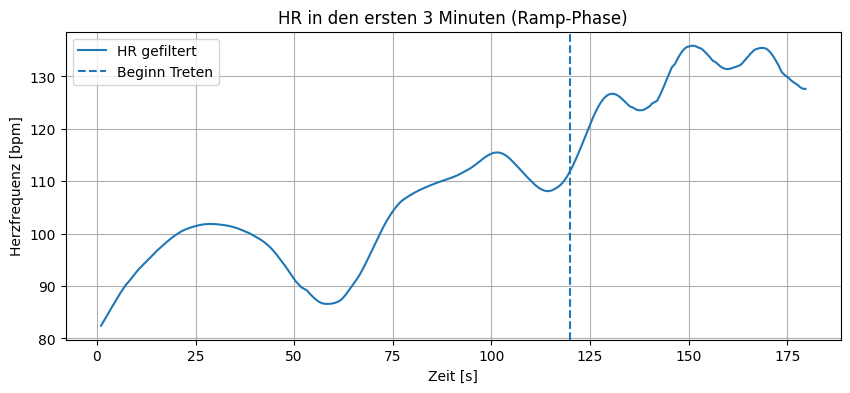

Im Bericht beschreibst du hier z.B.:
- wie die HR ansteigt
- warum Start der Übung und HR-Anstieg nicht exakt gleichzeitig sind (Verzögerung im Kreislauf).


In [ ]:
# Zeit (in Sekunden), zu der das Treten begonnen hat (TODO: aus Protokoll eintragen)
t_start_exercise = 120.0  # Beispielwert!

t0 = 0.0
t1 = 180.0  # erste 3 Minuten

mask_ramp = (hr_time_ex >= t0) & (hr_time_ex <= t1)

fig, ax = plt.subplots()
ax.plot(hr_time_ex[mask_ramp], hr_filt_ex[mask_ramp], label="HR gefiltert")
ax.axvline(t_start_exercise, linestyle="--", label="Beginn Treten")

ax.set_xlabel("Zeit [s]")
ax.set_ylabel("Herzfrequenz [bpm]")
ax.set_title("HR in den ersten 3 Minuten (Ramp-Phase)")
ax.legend()
plt.show()

print("Im Bericht beschreibst du hier z.B.:")
print("- wie die HR ansteigt")
print("- warum Start der Übung und HR-Anstieg nicht exakt gleichzeitig sind (Verzögerung im Kreislauf).")


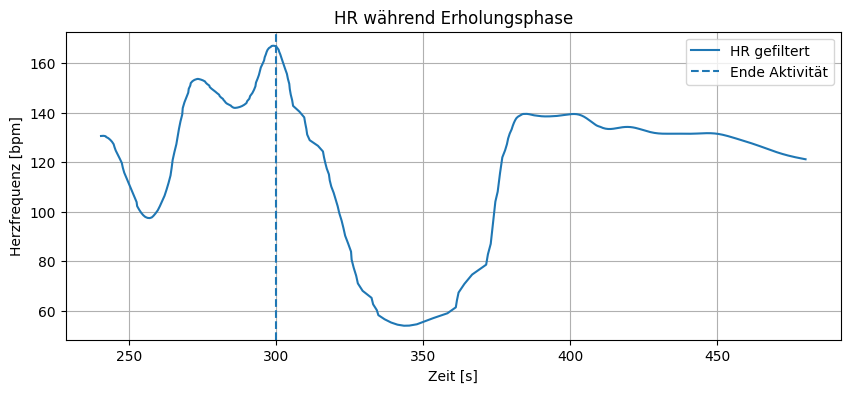

Im Bericht beantwortest du:
- kommt die HR wieder zum Ruhepuls zurück und wie lange dauert das?
- warum dauert das so lange?
- warum Athleten typischerweise eine schnellere Erholung haben?


In [ ]:
# Zeitpunkt in Sekunden, zu dem das Treten gestoppt wurde (TODO: anpassen)
t_stop_exercise = 300.0  # Beispielwert!

t_rec_start = t_stop_exercise - 60.0   # 1 Minute davor
t_rec_end   = t_stop_exercise + 180.0  # 3 Minuten danach

mask_rec = (hr_time_ex >= t_rec_start) & (hr_time_ex <= t_rec_end)

fig, ax = plt.subplots()
ax.plot(hr_time_ex[mask_rec], hr_filt_ex[mask_rec], label="HR gefiltert")
ax.axvline(t_stop_exercise, linestyle="--", label="Ende Aktivität")

ax.set_xlabel("Zeit [s]")
ax.set_ylabel("Herzfrequenz [bpm]")
ax.set_title("HR während Erholungsphase")
ax.legend()
plt.show()

print("Im Bericht beantwortest du:")
print("- kommt die HR wieder zum Ruhepuls zurück und wie lange dauert das?")
print("- warum dauert das so lange?")
print("- warum Athleten typischerweise eine schnellere Erholung haben?")


In [ ]:
# --- Parameter der Versuchsperson ---
# Trage hier deine Personendaten ein (für die Gleichung aus dem Paper):
body_mass_kg = 70.0   # Körpermasse in kg (Beispiel)
age_years    = 24.0   # Alter
sex          = "M"    # oder "F"

# --- Beispiel-Gerüst für die Hiilloskorpi-Gleichung ---
def energy_expenditure_hiilloskorpi(hr_bpm, body_mass_kg, age_years, sex):
    """
    Platzhalter-Funktion.

    TODO:
    - Aus dem Paper die passende Gleichung auswählen
    - Parameter (a, b, c, ...) einsetzen
    - Output: Energie pro Minute (z.B. in kJ/min oder kcal/min)

    Hier ist nur ein schematisches Beispiel ohne reale Koeffizienten.
    """
    # Beispielstruktur (fiktive Werte, bitte mit Paper ersetzen!):
    # if sex == "M":
    #     a, b, c = ...
    # else:
    #     a, b, c = ...
    # EE_kJ_per_min = a + b * hr_bpm + c * body_mass_kg
    # return EE_kJ_per_min

    # Bis du die echten Koeffizienten einsetzt, geben wir 0 zurück,
    # damit der restliche Code trotzdem läuft.
    return np.zeros_like(hr_bpm, dtype=float)


# --- Energieverbrauch über Zeit aus der HR-Kurve des Belastungsversuchs ---

# EE pro Minute für jede HR-Messung
EE_series = energy_expenditure_hiilloskorpi(hr_filt_ex, body_mass_kg, age_years, sex)

# Zeitabstände (in Minuten), weil hr_time_ex nicht exakt gleichabständig ist
dt = np.diff(hr_time_ex, prepend=hr_time_ex[0]) / 60.0  # Sekunden -> Minuten
EE_total_units = np.sum(EE_series * dt)  # Gesamteinheit entsprechend deiner Gleichung

print("Hinweis: EE_total_units hängt von der Einheit der Gleichung ab (z.B. kJ oder kcal).")


Hinweis: EE_total_units hängt von der Einheit der Gleichung ab (z.B. kJ oder kcal).


In [ ]:
# --- Umrechnungen: Joule, kcal, Rittersport, Bier, Anteil Tagesbedarf ---

# TODO: Sobald du weißt, ob EE_total_units kJ oder kcal sind, setze die Umrechnung korrekt.

# Beispiel: wir nehmen an, EE_total_units ist in kcal
EE_total_kcal = EE_total_units
EE_total_J = EE_total_kcal * 4184.0  # 1 kcal = 4184 J

# Schätzwerte (bitte bei Bedarf anpassen):
KCAL_PER_RITTERSPORT = 550.0   # grobe Annahme pro Tafel
KCAL_PER_BEER_05L    = 200.0   # grobe Annahme pro 0.5L-Bier

n_ritter = EE_total_kcal / KCAL_PER_RITTERSPORT
n_beer   = EE_total_kcal / KCAL_PER_BEER_05L

# Täglicher Kalorienbedarf (z.B. grob per Formel / Online-Rechner bestimmen)
daily_need_kcal = 2200.0  # Beispielwert

fraction_of_daily = EE_total_kcal / daily_need_kcal

print(f"Gesamter Energieverbrauch (angenommen in kcal): {EE_total_kcal:.1f} kcal")
print(f"Das entspricht etwa {n_ritter:.2f} Rittersport-Tafeln")
print(f"oder ca. {n_beer:.2f} Bier (0.5L)")
print(f"Anteil am täglichen Bedarf: {fraction_of_daily*100:.1f} % (bei {daily_need_kcal:.0f} kcal/Tag)")


Gesamter Energieverbrauch (angenommen in kcal): 0.0 kcal
Das entspricht etwa 0.00 Rittersport-Tafeln
oder ca. 0.00 Bier (0.5L)
Anteil am täglichen Bedarf: 0.0 % (bei 2200 kcal/Tag)
